# Sentiment Analysis Using Twitter ($\mathbb{X}$) Data
## Cleaning and Exploring Twitter Data using RegEx

## Goals

Hey there! In this notebook, I will be exploring tweets from several high-profile Twitter users.  

I'll be exploring the following areas:
* Conducting data cleaning and EDA on a text-based dataset,
* Manipulating data in `pandas` with the `datetime` and `string` accessors,
* Writing regular expressions and using `pandas` RegEx methods, and
* Performing sentiment analysis on social media using VADER.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from utils import *


pd.set_option('max_colwidth', 280)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")

def horiz_concat_df(dict_of_df, head=None):
    """
    Horizontally concatenante multiple DataFrames for easier visualization.
    Each DataFrame must have the same columns.
    """
    df = pd.concat([df.reset_index(drop=True) for df in dict_of_df.values()], axis=1, keys=dict_of_df.keys())
    if head is None:
        return df
    return df.head(head)

## About the Data

Disclosure: The data for this task was obtained using the [Twitter APIs](https://developer.twitter.com/en/docs/twitter-api). If you want access to the data, please message me on [LinkedIn](https://www.linkedin.com/in/sanjana-g/) with a note.

In [3]:
from os import listdir
for f in listdir("data"):
    print(f)

EmmanuelMacron_recent_tweets.txt
Cristiano_recent_tweets.txt
elonmusk_recent_tweets.txt
BillGates_recent_tweets.txt
BernieSanders_recent_tweets.txt
AOC_recent_tweets.txt


<br>

---

Let's start by examining the contents of one of these files. I have chosen to view BernieSanders' recent tweets. You can choose to view anything you like!


In [4]:
with open('data/BernieSanders_recent_tweets.txt', 'r') as f:
    data = f.read(1000)
print(data)

[{"created_at": "Sat Feb 06 22:43:03 +0000 2021", "id": 1358184460794163202, "id_str": "1358184460794163202", "full_text": "Why would we want to impeach and convict Donald Trump \u2013 a president who is now out of office? Because it must be made clear that no president, now or in the future, can lead an insurrection against the government he or she is sworn to protect.", "truncated": false, "display_text_range": [0, 243], "entities": {"hashtags": [], "symbols": [], "user_mentions": [], "urls": []}, "source": "<a href=\"http://twitter.com/download/iphone\" rel=\"nofollow\">Twitter for iPhone</a>", "in_reply_to_status_id": null, "in_reply_to_status_id_str": null, "in_reply_to_user_id": null, "in_reply_to_user_id_str": null, "in_reply_to_screen_name": null, "user": {"id": 216776631, "id_str": "216776631", "name": "Bernie Sanders", "screen_name": "BernieSanders", "location": "Vermont", "description": "U.S. Senator for Vermont. Not me, us.", "url": "https://t.co/jpg8Sp1GhR", "entities": {"

We note that the data is in JSON format!

# Compare the data loading time with (and without) cudf pandas accelerator

### Let's first install the RAPIDS library

This might take a few minutes

In [5]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 438, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 438 (delta 121), reused 57 (delta 54), pack-reused 269
Receiving objects: 100% (438/438), 118.31 KiB | 13.15 MiB/s, done.
Resolving deltas: 100% (223/223), done.
***********************************************************************
We will now install RAPIDS via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.2/955.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.8 MB/s eta 0:00:00
time: 450 µs (started: 2024-02-13 16:54:31 +00:00)


In [7]:
all_tweets = {f.split('_')[0]: pd.read_json("data/" + f).set_index('id') for f in listdir('data') if f.split('_')[0] in ['BillGates', 'AOC', 'Cristiano', 'elonmusk', 'EmmanuelMacron', 'BernieSanders']}

time: 20.2 s (started: 2024-02-13 16:54:38 +00:00)


#### It takes about seconds to load 82mb data without cudf pandas accelerator. Let's try with the cudf pandas accelerator extension!

In [9]:
# %load_ext cudf.pandas

time: 320 µs (started: 2024-02-13 16:55:38 +00:00)


In [ ]:
cudf_all_tweets = {f.split('_')[0]: pd.read_json("data/" + f).set_index('id') for f in listdir('data') if f.split('_')[0] in ['BillGates', 'AOC', 'Cristiano', 'elonmusk', 'EmmanuelMacron', 'BernieSanders']}

<br>

---

`pandas` has built-in readers for many different file formats, including the JSON format used here to store tweets.  So, let's use that to read the tweets.

In [33]:
tweets = {f.split('_')[0]: pd.read_json("data/" + f).set_index('id') for f in listdir('data') if f.split('_')[0] in ['AOC', 'Cristiano', 'elonmusk']}

Let's view the first 5 tweets for Elon Musk (and a lot of information about those tweets).

In [34]:
tweets["elonmusk"].head()

,created_at,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,favorite_count,favorited,retweeted,possibly_sensitive,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,quoted_status
id,,,,,,,,,,,,,,,,,,,,,
1357991946082418690,2021-02-06 09:58:04+00:00,1357991946082418688,The Second Last Kingdom https://t.co/Je4EI88HmV,False,"[0, 23]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 1357991942471094275, 'id_str': '1357991942471094275', 'indices': [24, 47], 'media_url': 'http://pbs.twimg.com/media/EtiOegrVEAMCgZE.jpg', 'media_url_https': 'https://pbs.twimg.com/media/EtiOegrV...","{'media': [{'id': 1357991942471094275, 'id_str': '1357991942471094275', 'indices': [24, 47], 'media_url': 'http://pbs.twimg.com/media/EtiOegrVEAMCgZE.jpg', 'media_url_https': 'https://pbs.twimg.com/media/EtiOegrVEAMCgZE.jpg', 'url': 'https://t.co/Je4EI88HmV', 'display_url': '...","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,...,352096,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN
1357973565413367808,2021-02-06 08:45:02+00:00,1357973565413367808,@DumDin7 @Grimezsz Haven’t heard that name in years …,False,"[19, 53]","{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'DumDin7', 'name': 'Dum Din', 'id': 1279896279733145601, 'id_str': '1279896279733145601', 'indices': [0, 8]}, {'screen_name': 'Grimezsz', 'name': '𝑪𝒍𝒂𝒊𝒓𝒆 𝒅𝒆 𝑳𝒖𝒏𝒆࿎', 'id': 276540738, 'id_str': '276540738', 'indi...",NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1.357973e+18,1.357973e+18,...,2155,False,False,NaN,en,NaN,NaN,NaN,NaN,NaN
1357972904663687173,2021-02-06 08:42:25+00:00,1357972904663687168,@Grimezsz Dogecake,False,"[10, 18]","{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'Grimezsz', 'name': '𝑪𝒍𝒂𝒊𝒓𝒆 𝒅𝒆 𝑳𝒖𝒏𝒆࿎', 'id': 276540738, 'id_str': '276540738', 'indices': [0, 9]}], 'urls': []}",NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1.357835e+18,1.357835e+18,...,5373,False,False,NaN,en,NaN,NaN,NaN,NaN,NaN
1357970517165182979,2021-02-06 08:32:55+00:00,1357970517165182976,YOLT\n\nhttps://t.co/cnOf9yjpF1,False,"[0, 29]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/cnOf9yjpF1', 'expanded_url': 'https://m.youtube.com/watch?v=05QJlF06F4s', 'display_url': 'm.youtube.com/watch?v=05QJlF…', 'indices': [6, 29]}]}",NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,...,62717,False,False,0.0,en,NaN,NaN,NaN,NaN,NaN
1357964347813687296,2021-02-06 08:08:24+00:00,1357964347813687296,@Kristennetten That’s Damian,False,"[15, 28]","{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'Kristennetten', 'name': 'K10✨', 'id': 985686123123949568, 'id_str': '985686123123949568', 'indices': [0, 14]}], 'urls': []}",NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",1.357964e+18,1.357964e+18,...,5726,False,False,NaN,en,NaN,NaN,NaN,NaN,NaN


<br>

---
### Food for thought!
There are many ways we could choose to read tweets. Why might someone be interested in doing data analysis on tweets? Who do you think (eg: person, institution) might be interested in this kind of analysis? Why a data analysis of tweets might be interesting or useful for them?

_Micro-blogging platforms like Twitter (X) is a great place for businesses to learn about their products/services and the feedback. Product/Service users may be willing to discuss their thoughts with others in this platform out of their own will. So, these reviews could be considered authentic. Therefore, product/service companies would want to analyse the tweets to better serve their customers._

<br/>
<hr style="border: 1px solid #fdb515;" />

## Source Analysis

In some cases, the Twitter feed of a public figure may be partially managed by a public relations firm. In these cases, the device used to post the tweet may help reveal whether it was the individual (e.g., from an iPhone) or a public relations firm (e.g., TweetDeck). The tweets we have collected contain the source information, but it is formatted strangely. So, let's take a peek!

In [35]:
tweets["Cristiano"][["source"]]

,source
id,
1358137564587319299,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
1357379984399212545,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
1356733030962987008,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
1355924395064233986,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
1355599316300292097,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>"
...,...
32514882561638401,"<a href=""http://www.whosay.com"" rel=""nofollow"">WhoSay</a>"
32513604662071296,"<a href=""http://www.whosay.com"" rel=""nofollow"">WhoSay</a>"
32511823722840064,"<a href=""http://www.whosay.com"" rel=""nofollow"">WhoSay</a>"


Let us use a regular expression (and gain experience with capture groups!) to convert this messy HTML snippet into something more readable.  For example: I am trying to extract `Twitter for iPhone` from the sentence `<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>`

<br>

---
### Source Extraction


In [36]:
pattern = r'>([\w\s]+)<'
test_str = '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'
re.findall(pattern, test_str)

['Twitter for iPhone']

It works for one! Let's do this for the entire DataFrame.

In [37]:
for name in tweets.keys():
    tweets[name]['device'] = tweets[name]['source'].str.extract(pattern)


<br>

---
### What are the most frequently used devices by each individual?


In [38]:
def most_freq(series, k = 5):
    return series.value_counts()[:k]

most_freq(tweets["Cristiano"]['device'])

Twitter for iPhone     1183
Twitter Web Client      959
WhoSay                  453
Twitter for Android     108
Twitter for iPad         92
Name: device, dtype: int64

### Let's create a plot describing the top 5 most commonly used devices for each user.

In [39]:
device_counts = pd.DataFrame(
    [most_freq(tweets[name]['device']).rename(name)
     for name in tweets]
).fillna(0)

device_counts

,Twitter for iPhone,Twitter Web Client,WhoSay,Twitter for Android,Twitter for iPad,Twitter Media Studio,Twitter Web App
Cristiano,1183.0,959.0,453.0,108.0,92.0,0.0,0.0
AOC,3245.0,0.0,0.0,0.0,0.0,2.0,0.0
elonmusk,3202.0,0.0,0.0,0.0,0.0,0.0,37.0


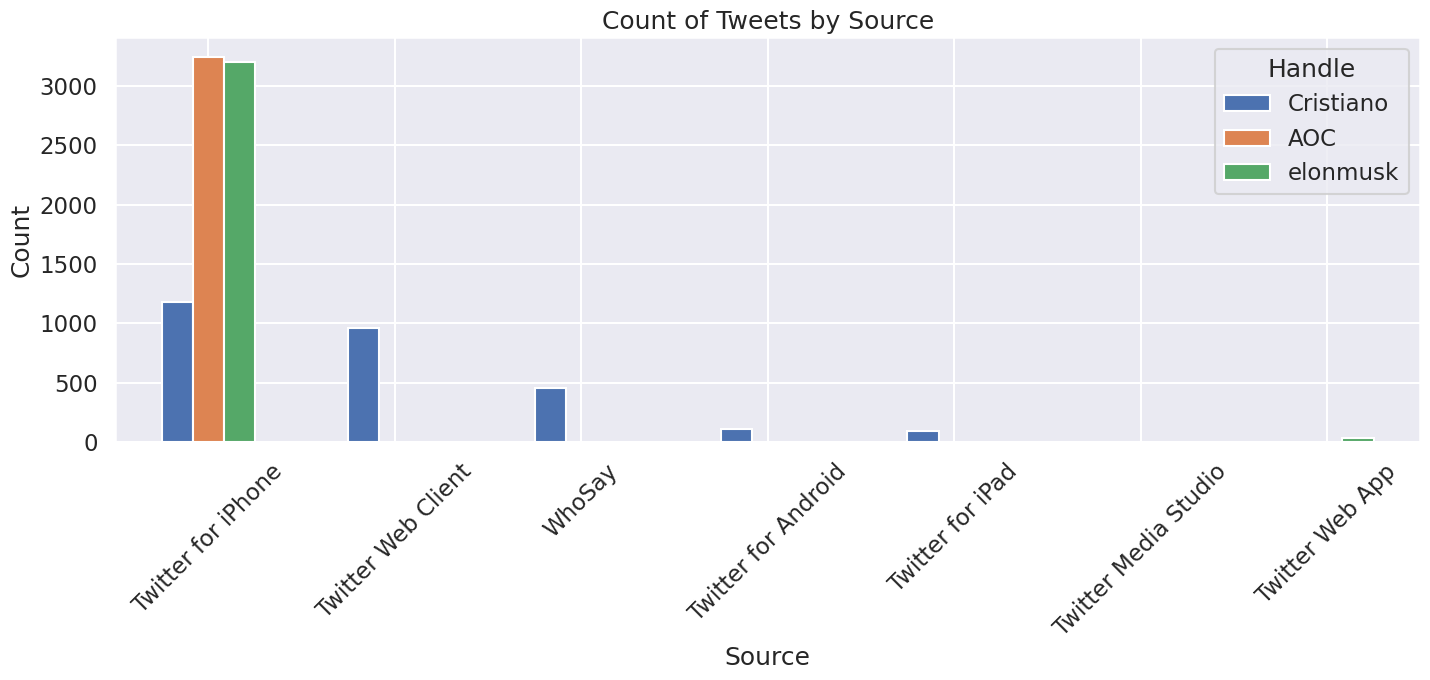

In [40]:
make_bar_plot(device_counts.T, title="Count of Tweets by Source",
               xlabel="Source", ylabel="Count")
plt.xticks(rotation=45)
plt.legend(title="Handle");


---
### Questions that I intend to ask as a part of the EDA.



_1. Does the user prefer to use a specific device at a specific period of the day?_
<br>
_2. Does the topic that the user tweets about depends on the device that is being used?_
<br>
_3. Is there an inclination to use a specific set of words (or vocabulary) based on the device? -- This might speak for the identity of the user who might be tweeting on behalf of the individual who owns the account._

---
### Observations


_First, using the proportion of tweets from different devices (instead of the count) will help understand the user's device preference relatively. It is also seen that not every user is using all of the platforms for tweeting. Also, the number of tweets from users are not equal. Therefore, working with the proportion provides fairness to those users that have lower tweet counts compared to others._

<br/>
<hr style="border: 1px solid #fdb515;" />

## Time Series Analysis of Tweets

Now that we've explored the sources of each of the tweets, we will perform some time series analysis. A look into the temporal aspect of the data could reveal insights about how a user spends their day, when they eat and sleep, etc.


In [41]:
def add_hour(df, time_col, result_col):
    df[result_col] = df[time_col].dt.hour + df[time_col].dt.minute/60 + df[time_col].dt.second/(60*60)
    return df

tweets = {handle: add_hour(df, "created_at", "hour") for handle, df in tweets.items()}
tweets["AOC"]["hour"].head()

id
1358149122264563712    20.377222
1358147616400408576    20.277500
1358145332316667909    20.126389
1358145218407759875    20.118611
1358144207333036040    20.051667
Name: hour, dtype: float64

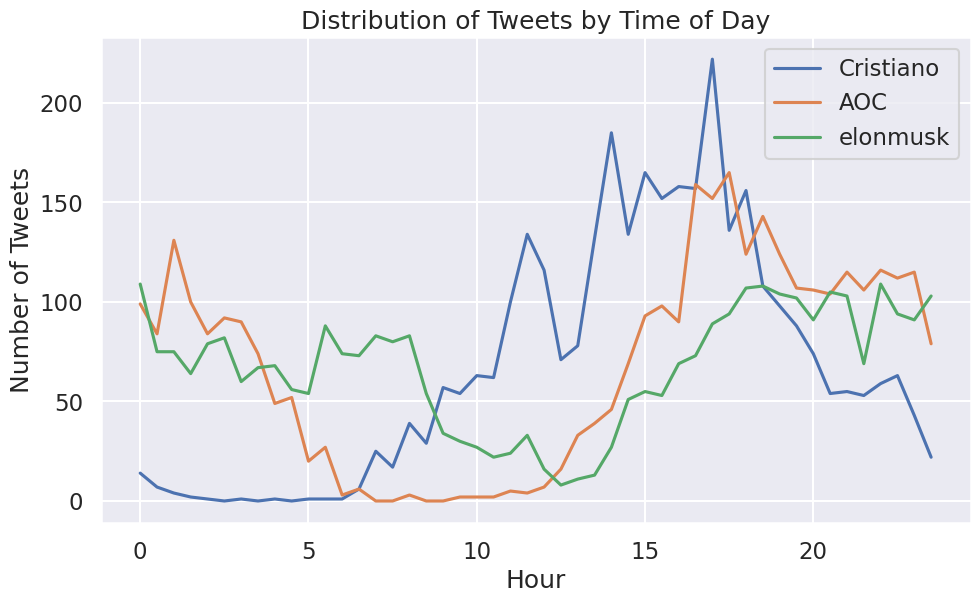

In [42]:
def bin_df(df, bins, colname):
    binned = pd.cut(df[colname], bins).value_counts().sort_index()
    return pd.DataFrame({"counts": binned, "bin": bins[:-1]})

hour_bins = np.arange(0, 24.5, .5)
binned_hours = {handle: bin_df(df, hour_bins, "hour") for handle, df in tweets.items()}

make_line_plot(binned_hours, "bin", "counts", title="Distribution of Tweets by Time of Day",
               xlabel="Hour", ylabel="Number of Tweets")

<br>

---
### Observations

_Tweets from Christiano's account has been very low during the hours 0-6. While for Elon Musk and AOC, the tweeting activity declines over the first 6 hours. Even between Elon Musk and AOC, there is a small shift in the curve. It could be due to the timezones in which they're based out.  The data plotted seems reasonable, given that the users primary locations are different. But, we can align the data for making the reasoning easier._

<br>

---
### Convert Timezone

We are doing this to account for the different locations of each user

In [43]:
def convert_timezone(df, new_tz):
    df['converted_time'] = df['created_at'].dt.tz_convert(new_tz)
    return df

timezones = {"AOC": "EST", "Cristiano": "Europe/Lisbon", "elonmusk": "America/Los_Angeles"}

tweets = {handle: convert_timezone(tweets[handle], timezones[handle]) for handle in tweets.keys()}

With our adjusted timestamps for each user based on their timezone, let's take a look again at the distribution of tweets by time of day.

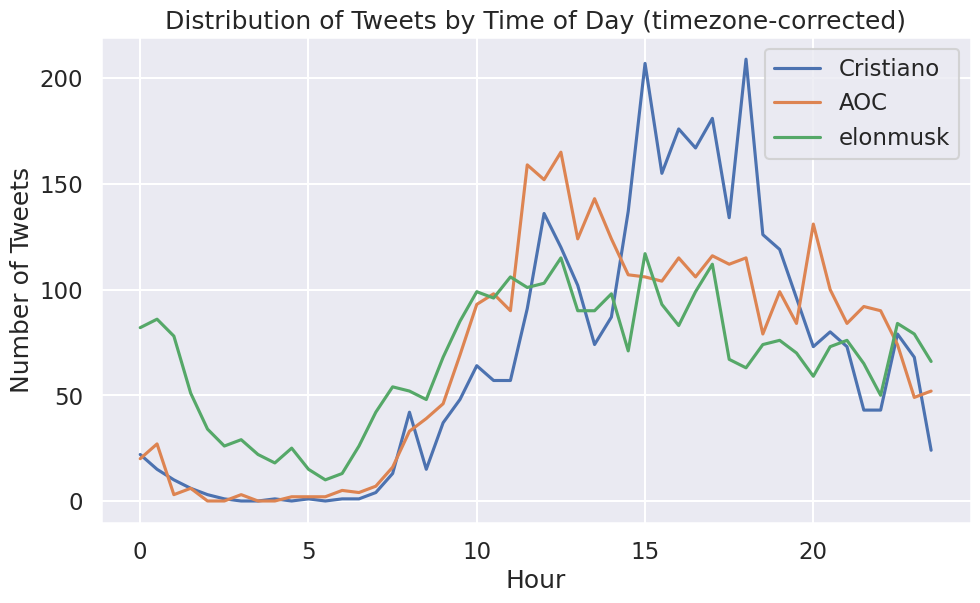

In [44]:
tweets = {handle: add_hour(df, "converted_time", "converted_hour") for handle, df in tweets.items()}
binned_hours = {handle: bin_df(df, hour_bins, "converted_hour") for handle, df in tweets.items()}

make_line_plot(binned_hours, "bin", "counts", title="Distribution of Tweets by Time of Day (timezone-corrected)",
               xlabel="Hour", ylabel="Number of Tweets")

<hr style="border: 1px solid #fdb515;" />


## Sentiment Analysis

We will use the VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon ([github](https://github.com/cjhutto/vaderSentiment), [original paper](https://doi.org/10.1609/icwsm.v8i1.14550)) to analyze the sentiment of AOC's tweets. Check out the documentation [here](https://github.com/cjhutto/vaderSentiment#resources-and-dataset-descriptions) for more information.


In [45]:
print(''.join(open("vader_lexicon.txt").readlines()[:10]))

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]



In [46]:
sent = pd.read_csv('vader_lexicon.txt', sep='\t', index_col=[0], usecols=[0,1], names=['token', 'polarity'])
sent.head()
# print(sent.shape)

,polarity
token,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7


<br>

---
### Remove Punctuations

In [47]:
punct_re = r'[^\s\w]'
re.sub(punct_re, " ", tweets["AOC"].iloc[0]["full_text"])

'RT  RepEscobar  Our country has the moral obligation and responsibility to reunite every single family separated at the southern border \n\nT '

### Find mentions in tweets

In [48]:
mentions_re = r'@([\w]+)'
re.findall(mentions_re, tweets["AOC"].iloc[0]["full_text"])

['RepEscobar']

<br/>

####To calculate the sentiments for a sentence, we will follow this procedure:

1. Remove the punctuation from each tweet so we can analyze the words.
2. For each tweet, find the sentiment of each word.
3. Calculate the sentiment of each tweet by taking the sum of the sentiments of its words.

In [49]:
def sanitize_texts(df):
    df['clean_text'] = df["full_text"].str.lower().replace(punct_re, " ", regex=True)
    return df

tweets = {handle: sanitize_texts(df) for handle, df in tweets.items()}
tweets["AOC"]["clean_text"].head()

id
1358149122264563712                                                                                       rt  repescobar  our country has the moral obligation and responsibility to reunite every single family separated at the southern border \n\nt 
1358147616400408576                                                                                      rt  rokhanna  what happens when we guarantee  15 hour \n\n  31  of black workers and 26  of latinx workers get raises \n  a majority of essent 
1358145332316667909                                                                                                                                                                                                     source  https   t co 3o5jer6zpd 
1358145218407759875                                                 joe cunningham pledged to never take corporate pac money  and he never did  mace said she ll cash every check she gets  yet another way this is a downgrade  https   t co dytsqxkxgu
1


---
#### With the sanitized texts, we can extract all the user mentions from tweets.

In [50]:
def extract_mentions(full_texts):
    mentions = full_texts.str.lower().str.extractall(mentions_re).explode(0).reset_index().set_index(['id'])[[0]].rename( columns = {0:"twitter_handle"})
    return mentions[["twitter_handle"]]

# display(extract_mentions(tweets["AOC"]["full_text"]).head())

mentions = {handle: extract_mentions(df["full_text"]) for handle, df in tweets.items()}
display(extract_mentions(tweets["AOC"]["full_text"]).head())
display(extract_mentions(tweets["elonmusk"]["full_text"]).head())
display(extract_mentions(tweets["Cristiano"]["full_text"]).head())

,twitter_handle
id,
1358149122264563712,repescobar
1358147616400408576,rokhanna
1358130063963811840,jaketapper
1358130063963811840,repnancymace
1358130063963811840,aoc


,twitter_handle
id,
1357973565413367808,dumdin7
1357973565413367808,grimezsz
1357972904663687173,grimezsz
1357964347813687296,kristennetten
1357953080596172800,kristennetten


,twitter_handle
id,
1345294475300630535,sixpadhomegym
1343277423371186178,globe_soccer
1342772141708562432,pestanacr7
1340725769518116871,goldenfootofficial
1339997524841672704,herbalife


<br/>

### Tidying Up the Data

In [51]:
def to_tidy_format(df):
    tidy = (
        df["clean_text"]
        .str.split()
        .explode()
        .to_frame()
        .rename(columns={"clean_text": "word"})
    )
    return tidy

tidy_tweets = {handle: to_tidy_format(df) for handle, df in tweets.items()}
tidy_tweets["AOC"].head()

,word
id,
1358149122264563712,rt
1358149122264563712,repescobar
1358149122264563712,our
1358149122264563712,country
1358149122264563712,has


### Adding in the Polarity Score

Now that we have this table in a tidy format, it becomes much easier to find the sentiment of each tweet: we can join the table with the lexicon table.


In [52]:
def add_polarity(df, tidy_df):
    df["polarity"] = (
        tidy_df
        .merge(sent, how='left', left_on='word', right_index=True)
        .reset_index()
        .loc[:, ['id', 'polarity']]
        .fillna(0)
        .groupby('id')
        .sum()
    )
    return df

tweets = {handle: add_polarity(df, tidy_df) for (handle, df), tidy_df in \
          zip(tweets.items(), tidy_tweets.values())}
tweets["AOC"][["clean_text", "polarity"]].head()

,clean_text,polarity
id,,
1358149122264563712,rt repescobar our country has the moral obligation and responsibility to reunite every single family separated at the southern border \n\nt,0.0
1358147616400408576,rt rokhanna what happens when we guarantee 15 hour \n\n 31 of black workers and 26 of latinx workers get raises \n a majority of essent,1.0
1358145332316667909,source https t co 3o5jer6zpd,0.0
1358145218407759875,joe cunningham pledged to never take corporate pac money and he never did mace said she ll cash every check she gets yet another way this is a downgrade https t co dytsqxkxgu,0.0
1358144207333036040,what s even more gross is that mace takes corporate pac money \n\nshe s already funded by corporations now she s choosing to swindle working people on top of it \n\npeak scam artistry caps for cash https t co ccvxgdf6id,-6.4


<br>

---
#### Finally, with our polarity column in place, we can explore how the sentiment of each tweet relates to the user(s) mentioned in it.

In [53]:
def mention_polarity(df, mention_df):
    return df[['polarity']].join(mention_df, on='id').set_index('twitter_handle').groupby(['twitter_handle'])['polarity'].mean()

aoc_mention_polarity = mention_polarity(tweets["AOC"],mentions["AOC"]).sort_values(ascending=False)
aoc_mention_polarity

twitter_handle
booker4ky          15.4
texasaflcio        12.8
davidscottjaffe    12.6
teamwarren         12.6
padmalakshmi       12.3
                   ... 
meggiebaer         -8.6
manhattanda       -10.8
scotthech         -10.8
repmarktakano     -10.8
repchuygarcia     -10.8
Name: polarity, Length: 1182, dtype: float64

### Thoughts on using mean as an aggregate function

_By using mean as an aggregation function, we are concealing a lot of information about the range of sentiment scores of tweets mentioning each user. For example, when there is an outlier in the data, the mean value for the given user shifts towards the outlier. Mean doesn't tell about the range of sentiment scores. Two users may have the same mean sentiment score, but one of them might have a wide range (from highly positive to highly negative sentiment score), while for another user, all the score could be equal to that of the mean sentiment score. The weightage provided for each sentiment score is the same, which need not necessarily happen. We can use median, standard deviation, or define custom aggregate function (like, weighted mean) in place of mean to have a better measure of sentiment scores._

<br/>

<hr style="border: 1px solid #fdb515;" />


## Some more EDA!

_What are the hashtags used by AOC in the tweets?
What are the mean polarity and retweet counts for each of the tweets that contain those hashtags?
Amongst the tweets with the hashtag and is the most retweeted tweets, what does the mix of polarity look like?
Are negative polarity tweets with hashtags getting retweeted the most? I would like to analyse the top 10 values sorted by descending order of retweet_count._


## Steps

_I create a regex pattern for extracting the hashtags and a new dataframe that contains the id of the tweets and the hashtag.
Then, I join the tweets tables and the hashtag dataframe and pick only the dataframe corresponding to AOC. Using the mean aggregate function, I compute the mean polarity and retweet counts for the tweets containing the hashtags._

In [54]:
hashtag_re = r'#([\w]+)'

def extract_hashtags(full_texts):
    tag = full_texts.str.lower().str.extractall(hashtag_re).explode(0).reset_index().set_index(['id'])[[0]].rename( columns = {0:"hashtag"})
    return tag[["hashtag"]]

tags = {handle: extract_hashtags(df["full_text"]) for handle, df in tweets.items()}

elon_tags_df = tags['AOC']
elon_tweets_df = tweets['AOC']

merged_df = elon_tweets_df[['polarity', 'retweet_count']].join(elon_tags_df, on='id').set_index('hashtag').groupby(['hashtag']).mean().sort_values(ascending=[False], by=[ 'retweet_count'])
merged_df.head(10)

,polarity,retweet_count
hashtag,,
rayshardbrooks,-15.2,80543.000000
patient31,2.6,61993.000000
socialdi,2.6,61993.000000
cancelstudentdebt,-6.1,40410.000000
breonnataylor,-3.7,37390.600000
ahmaudaubrey,0.0,33543.000000
strikeforblacklives,3.1,30127.000000
primeday,1.4,29625.000000
markzuckerberg,7.4,27527.000000


<br>

---
### EDA observation



_We notice that AOC's most retweeted tweet with hashtag has a negative polarity. Of the top 10 most retweeted tweets with hashtags, there are four hashtags with negative polarity. The other 6 have positive polarity. It is strange to see srtikeforblacklives has a mean positive polarity, yet tweets containing #rayshardbrooks have highly negavity polarity. I would have expected both have the same sign of polarity._